<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -20px">
        <strong>Curso:</strong> Procesamiento de Lenguaje Natural 
        <strong>Sección:</strong> 10
      </p>
      <p style="font-size: 16px; margin: 0;"><strong>Laboratorio 4:</strong> Generación de textos con bigramas y evaluación de perplejidad</p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autor:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
      </ul>
    </td>
  </tr>
</table>

In [228]:
import nltk
nltk.download('cess_esp')

[nltk_data] Downloading package cess_esp to
[nltk_data]     C:\Users\daher\AppData\Roaming\nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


True

In [229]:
from nltk import bigrams, ngrams, ConditionalFreqDist
from collections import Counter, defaultdict
from nltk.corpus import cess_esp
import matplotlib.pyplot as plt
import random
import math
import re

In [230]:
# Load the CESS-ESP corpus
corpus = cess_esp.sents()

Un elemento detectado es que el corpus utiliza marcas para identificar patrones sintácticos. Por ejemplo -Fpa-, -Fpt- y *0*, pero como el objetivo del laboratorio es generar texto fluido con bigramas, se procede a filtrarlos.

In [231]:
def removeSpecialTags(sentences):
    """
    Elimina tokens como -Fpa-, -Fpt- (rodeados por guiones)
    y tokens como *0*, *1* (placeholders de anotación sintáctica)
    en el corpus cess_esp.
    """
    cleaned = []
    for sentence in sentences:
        cleaned_sentence = [
            word for word in sentence
            if not (word.startswith('-') and word.endswith('-'))  # -Fpa-, -Fpt-
            and not re.fullmatch(r"\*\d+\*", word)                # *0*, *1*, etc.
        ]
        cleaned.append(cleaned_sentence)
    return cleaned

comments = removeSpecialTags(corpus)

In [232]:
comments = [' '.join(sent) for sent in comments]
comments[:10]

['El grupo estatal Electricité_de_France EDF anunció hoy , jueves , la compra del 51_por_ciento de la empresa mexicana Electricidad_Águila_de_Altamira EAA , creada por el japonés Mitsubishi_Corporation para poner_en_marcha una central de gas de 495 megavatios .',
 'Una portavoz de EDF explicó a EFE que el proyecto para la construcción de Altamira_2 , al norte de Tampico , prevé la utilización de gas natural como combustible principal en una central de ciclo combinado que debe empezar a funcionar en mayo_del_2002 .',
 'La electricidad producida pasará a la red eléctrica pública de México en_virtud_de un acuerdo de venta de energía de EAA con la Comisión_Federal_de_Electricidad CFE por una duración de 25 años .',
 'EDF , que no quiso revelar cuánto pagó por su participación mayoritaria en EAA , intervendrá como asistente en la construcción de Altamira_2 y , posteriormente , se encargará de explotarla como principal accionista .',
 'EDF y Mitsubishi participaron en 1998 en la licitación d

# Estandarización del corpus

Se buscar analizar el efecto de la estandarización para identificar si existen apariciones de nuevas palabras con más repeticiones o simplemente, aumenta el número de las que actualmente se encuentran como más frecuentes. Para esto, se mostraran las 8 palabras más frecuentes antes del proceso y después del mismo. 

In [233]:
comments = [comment.strip() for comment in comments if comment.strip()]

def top_n_words(comments, n=8):
    from collections import Counter
    words = [word for comment in comments for word in comment.split()]
    return Counter(words).most_common(n)

print("Top 8 common words:")
print(top_n_words(comments))

Top 8 common words:
[(',', 11420), ('de', 10234), ('la', 6412), ('.', 5866), ('que', 5552), ('el', 5199), ('en', 4340), ('y', 4235)]


Para verificar si será necesario aplicar la transformación de mayusculas a mínusculas, se desarrolla una función que permite observar si una palabra tiene una equivalente en con algún caracter en mayúscula o minúscula en el corpus.

In [234]:
def encontrar_variaciones_de_casing(comments, max_resultados=3):
    formas_por_palabra = {}
    resultados_mostrados = 0

    for comment in comments:
        for word in comment.split():
            base = word.lower()
            if base not in formas_por_palabra:
                formas_por_palabra[base] = set()
            formas_por_palabra[base].add(word)

    for base, formas in formas_por_palabra.items():
        if len(formas) > 1:
            print(f"Variantes de '{base}': {formas}")
            resultados_mostrados += 1
            if resultados_mostrados >= max_resultados:
                break


print("Words with case variations:")
encontrar_variaciones_de_casing(comments)

Words with case variations:
Variantes de 'el': {'el', 'EL', 'El'}
Variantes de 'grupo': {'Grupo', 'grupo'}
Variantes de 'anunció': {'anunció', 'Anunció'}


Observamos que sí existen casos con variantes mayusculas y minusculas, por lo que sí se considera necesaria su aplicación. Además, se procede a analizar si ocurre lo mismo pero con signos de puntuación.

In [235]:
def encontrar_variaciones_de_puntuacion(comments, max_resultados=3):
    formas_por_palabra = {}
    resultados_mostrados = 0
    signos = ".!?,;:()\"'¿¡"

    for comment in comments:
        for word in comment.split():
            base = word.strip(signos)
            if base not in formas_por_palabra:
                formas_por_palabra[base] = set()
            formas_por_palabra[base].add(word)

    for base, formas in formas_por_palabra.items():
        if len(formas) > 1:
            print(f"Variantes de puntuación para '{base}': {formas}")
            resultados_mostrados += 1
            if resultados_mostrados >= max_resultados:
                break

print("Words with punctuation variations:")
encontrar_variaciones_de_puntuacion(comments)

Words with punctuation variations:
Variantes de puntuación para '': {':', '¿', "'", '?', '!', '"', '.', '...', '¡', ',', ';'}
Variantes de puntuación para 'PP': {'PP', 'PP.'}
Variantes de puntuación para '2': {'2', '2.'}


De esta forma identificamos que también se producen ocurrencias, por lo que se aplica el procedimiento de eliminación de puntuación

In [236]:
def erasePunctuation(comments):
    return [re.sub(r'[^\w\s]', '', line) for line in comments]

In [237]:
def replaceUnderscore(comments):
    return [line.replace('_', ' ') for line in comments]

Se procede con la estandarización y se evalua el resultado.

In [238]:
comments = [comment.lower() for comment in comments]
comments = erasePunctuation(comments)

print("Top 8 common words after standardization:")
print(top_n_words(comments))  

Top 8 common words after standardization:
[('de', 10286), ('la', 6925), ('el', 6013), ('que', 5570), ('en', 4643), ('y', 4349), ('los', 3189), ('a', 3020)]


Se puede apreciar que existe un aumento en la frecuencia de algunas palabras, por lo tanto, la estandarización es efectiva. 

In [239]:
comments[:10]

['el grupo estatal electricité_de_france edf anunció hoy  jueves  la compra del 51_por_ciento de la empresa mexicana electricidad_águila_de_altamira eaa  creada por el japonés mitsubishi_corporation para poner_en_marcha una central de gas de 495 megavatios ',
 'una portavoz de edf explicó a efe que el proyecto para la construcción de altamira_2  al norte de tampico  prevé la utilización de gas natural como combustible principal en una central de ciclo combinado que debe empezar a funcionar en mayo_del_2002 ',
 'la electricidad producida pasará a la red eléctrica pública de méxico en_virtud_de un acuerdo de venta de energía de eaa con la comisión_federal_de_electricidad cfe por una duración de 25 años ',
 'edf  que no quiso revelar cuánto pagó por su participación mayoritaria en eaa  intervendrá como asistente en la construcción de altamira_2 y  posteriormente  se encargará de explotarla como principal accionista ',
 'edf y mitsubishi participaron en 1998 en la licitación de licencias p

Finalmente se identifica que existen varios epacios en blanco en la separación de algunas palabras, para evitar obtener bigramas incorrectos o que en algun punto de la estandarización afecten, se procede a normalizarlos.

In [240]:
def normalizeSpaces(lines):
    """
    Reemplaza múltiples espacios en blanco seguidos por un solo espacio.
    También elimina espacios iniciales/finales si los hay.
    """
    return [re.sub(r'\s+', ' ', line).strip() for line in lines]

In [241]:
comments = normalizeSpaces(comments)

In [242]:
comments[:10]

['el grupo estatal electricité_de_france edf anunció hoy jueves la compra del 51_por_ciento de la empresa mexicana electricidad_águila_de_altamira eaa creada por el japonés mitsubishi_corporation para poner_en_marcha una central de gas de 495 megavatios',
 'una portavoz de edf explicó a efe que el proyecto para la construcción de altamira_2 al norte de tampico prevé la utilización de gas natural como combustible principal en una central de ciclo combinado que debe empezar a funcionar en mayo_del_2002',
 'la electricidad producida pasará a la red eléctrica pública de méxico en_virtud_de un acuerdo de venta de energía de eaa con la comisión_federal_de_electricidad cfe por una duración de 25 años',
 'edf que no quiso revelar cuánto pagó por su participación mayoritaria en eaa intervendrá como asistente en la construcción de altamira_2 y posteriormente se encargará de explotarla como principal accionista',
 'edf y mitsubishi participaron en 1998 en la licitación de licencias para construir

De esta forma se procede a almacenar el corpus estandarizado.

In [243]:
with open("corpus.txt", "w", encoding="utf-8") as file:
    for comment in comments:
        file.write(comment + "\n")

## Modelo basado en bigramas

Los modelos basados en bigramas requieren de una tokenización de los elementos para luego ser procesados mediante la formula condicional P(w2 | w1) usando frecuencias relativas.

In [244]:
# Carga y tokenización del corpus estandarizado
with open("corpus.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

tokens = []
for line in lines:
    words = line.strip().split()
    tokens.extend(words)

tokens[:20]

['el',
 'grupo',
 'estatal',
 'electricité_de_france',
 'edf',
 'anunció',
 'hoy',
 'jueves',
 'la',
 'compra',
 'del',
 '51_por_ciento',
 'de',
 'la',
 'empresa',
 'mexicana',
 'electricidad_águila_de_altamira',
 'eaa',
 'creada',
 'por']

In [245]:
# Generación de bigramas
bigramsCorpus = list(bigrams(tokens))
bigramsCorpus[:20]

[('el', 'grupo'),
 ('grupo', 'estatal'),
 ('estatal', 'electricité_de_france'),
 ('electricité_de_france', 'edf'),
 ('edf', 'anunció'),
 ('anunció', 'hoy'),
 ('hoy', 'jueves'),
 ('jueves', 'la'),
 ('la', 'compra'),
 ('compra', 'del'),
 ('del', '51_por_ciento'),
 ('51_por_ciento', 'de'),
 ('de', 'la'),
 ('la', 'empresa'),
 ('empresa', 'mexicana'),
 ('mexicana', 'electricidad_águila_de_altamira'),
 ('electricidad_águila_de_altamira', 'eaa'),
 ('eaa', 'creada'),
 ('creada', 'por'),
 ('por', 'el')]

Con ayuda de nltk se construye un modelo de conteo condicional que permite calcular por cada palabra w1, cuántas veces aparece w2 después de la misma. Lo cual permite realizar el calculo de las probabilidades condicionales contando el total de ocurrencias por cada w1, usandolo como denominador de la frecuencia mencionada anteriormente.

In [246]:
# Construcción del modelo de conteo condicional
cfd = ConditionalFreqDist(bigramsCorpus)

bigramsProbability = {}
for w1 in cfd.conditions():
    total = cfd[w1].N()
    bigramsProbability[w1] = {}
    for w2 in cfd[w1]:
        prob = cfd[w1][w2] / total
        bigramsProbability[w1][w2] = prob  

# Mostrar las probabilidades condicionales de los 10 bigramas más frecuentes
bigramCount = Counter()

for w1 in cfd.conditions():
    for w2 in cfd[w1]:
        bigramCount[(w1, w2)] = cfd[w1][w2]

topBigrams = bigramCount.most_common(10)

print("\nTop 10 bigramas más frecuentes con probabilidad condicional:")
for (w1, w2), count in topBigrams:
    total_w1 = cfd[w1].N()
    prob = count / total_w1
    print(f"- P({w2}|{w1}) = {prob:.4f}  ({count} ocurrencias)")


Top 10 bigramas más frecuentes con probabilidad condicional:
- P(la|de) = 0.1468  (1510 ocurrencias)
- P(el|en) = 0.1878  (872 ocurrencias)
- P(los|de) = 0.0766  (788 ocurrencias)
- P(la|en) = 0.1581  (734 ocurrencias)
- P(la|a) = 0.1728  (522 ocurrencias)
- P(se|que) = 0.0750  (418 ocurrencias)
- P(las|de) = 0.0400  (411 ocurrencias)
- P(el|que) = 0.0680  (379 ocurrencias)
- P(que|lo) = 0.4496  (317 ocurrencias)
- P(la|que) = 0.0542  (302 ocurrencias)


## Generador de texto

Ahora se procede a realizar una función generadora de texto que permita generar una secuencia a partir del modelo lenguaje basado en bigramas. La forma en la que trabaja este es que a partir de una palabra inicial, se obtienen todas las posibles que pueden seguirlas en base a las probabilidades de los bigramas, entonces se escoge una de ellas aleatoriamente (en un enfoque estocástico) y se toma ahora esta como palabra inicial. Este proceso es repetido hasta llegar a la longitud determinada por el usuario.

In [247]:
def generateText(startWord, length=10):
    """
    Genera una secuencia de texto basada en bigramas a partir de una palabra inicial.
    """
    if startWord not in bigramsProbability:
        print(f"La palabra '{startWord}' no está en el vocabulario.")
        return ""

    currentWord = startWord
    text = [currentWord]

    for _ in range(length - 1):
        nextWords = list(bigramsProbability.get(currentWord, {}).keys())
        if not nextWords:
            break
        nextWord = random.choices(nextWords, weights=bigramsProbability[currentWord].values())[0]
        text.append(nextWord)
        currentWord = nextWord

    return ' '.join(text)

Entonces como ejemplo de uso se decide usar la palabra "de" como inicial ya que se determinó en el proceso de estandarización del corpus como más frecuente. 

In [248]:
textGenerated = generateText("de", length=20)
print("\nTexto generado:")
print(textGenerated)


Texto generado:
de rechazo de los costes de funcionamiento de 34 años que puede trasladal el colista sevilla a aznar cree batallar


## Perplejidad

La perplejidad es una medida que evalúa qué tan bien un modelo de lenguaje predice una secuencia. Mientras más baja, mejor es el modelo para esa secuencia.

Sin embargo, si una combinación condicional no aparece en el corpus, su probabilidad será de 0 y su perplejidad por lo tanto infinita, por esta razón la solución para esto es el suavizado de laplace que calcula probabilidades en base al tamaño del vocabulario.

In [249]:
def vocabSize(corpus):
    """
    Calcula el tamaño del vocabulario del corpus.
    """
    unique_words = set()
    for sentence in corpus:
        unique_words.update(sentence.split())
    return len(unique_words)

def calculatePerplexity(sentence, bigramsProbability, vocabSize):
    """
    Calcula la perplejidad de una secuencia de texto dada.
    """
    tokens = sentence.split()
    N = len(tokens)
    
    if N == 0:
        return float('inf')  # Perplejidad infinita para secuencias vacías

    log_prob_sum = 0.0
    for i in range(N - 1):
        w1, w2 = tokens[i], tokens[i + 1]
        prob = bigramsProbability.get(w1, {}).get(w2, 0)
        if prob == 0:
            prob = 1 / (vocabSize + 1)  # Suavizado de Laplace
        log_prob_sum += math.log(prob)

    perplexity = math.exp(-log_prob_sum / (N - 1))
    return perplexity

In [250]:
sentence = "el proyecto de la construcción"
vocabSizeC = vocabSize(comments)
pp = calculatePerplexity(sentence, bigramsProbability, vocabSizeC)
print(f"Perplejidad: {pp:.4f}")

sentence = "los niños juegan en el parque"
pp = calculatePerplexity(sentence, bigramsProbability, vocabSizeC)
print(f"Perplejidad: {pp:.4f}")

Perplejidad: 47.6810
Perplejidad: 218.4224


Al interpretar los resultados se evidencia que la primera oración tiene una perplejidad mucho menor que la segunda. Esto indica que el modelo considera este grupo de palabras como más probable dentro del corpus, lo cual sugiere que los bigramas observados aparecen con mayor frecuencia.

Por contraparte, la segunda oración tiene una perplejidad significativamente más alta probablemente porque sus bigramas son poco prefuentes o porque directamente no aparecen en el corpus, por lo que su probabilidad está estimada en base al suvizado de Laplace. 

Con lo cual, podemos determinar que el corpus está centrado en un lenguaje quizá más técnico y orientado a temas específicos.

## Evaluación de la perplejidad con diferentes tamaños de corpus

Se entrenaran modelos con corpus al 1%, 5%, 10%, 50% y 100% para evaluar la perplejidad sobre una misma oración de prueba con el objetivo de ver visualmente si a medida que se aumenta el porcentaje del corpues, la perplejidad sobre la oración se va reduciendo. Para esto se generará una pipeline de entrenamiento y visualización.

In [251]:
def trainBigramModel(comments):
    tokens = []
    for sentence in comments:
        tokens.extend(sentence.strip().split())

    bigrams_list = list(bigrams(tokens))
    cfd = ConditionalFreqDist(bigrams_list)

    bigramsProbability = {}
    for w1 in cfd.conditions():
        total = cfd[w1].N()
        bigramsProbability[w1] = {}
        for w2 in cfd[w1]:
            prob = cfd[w1][w2] / total
            bigramsProbability[w1][w2] = prob

    return bigramsProbability, len(set(tokens))

In [252]:
def evaluatePerplexityOverSizes(comments, testSentence, sizes=[0.01, 0.05, 0.1, 0.5, 1.0]):
    results = []
    for size in sizes:
        subset_size = int(len(comments) * size)
        comments = random.sample(comments, subset_size)
        bigramsProbability, vocabSizeC = trainBigramModel(comments)
        pp = calculatePerplexity(testSentence, bigramsProbability, vocabSizeC)
        results.append((size, pp))
    return results

In [253]:
def plotPerplexityResults(results):
    sizes, perplexities = zip(*results)
    percentLabels = [f"{s* 100:.0f}%" for s in sizes]
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, perplexities, marker='o')
    plt.xscale('log')
    plt.xlabel('Tamaño del corpus (%)')
    plt.ylabel('Perplejidad')
    plt.title('Perplejidad vs Tamaño del Corpus')
    plt.grid(True)
    plt.xticks(sizes, percentLabels)
    plt.show()

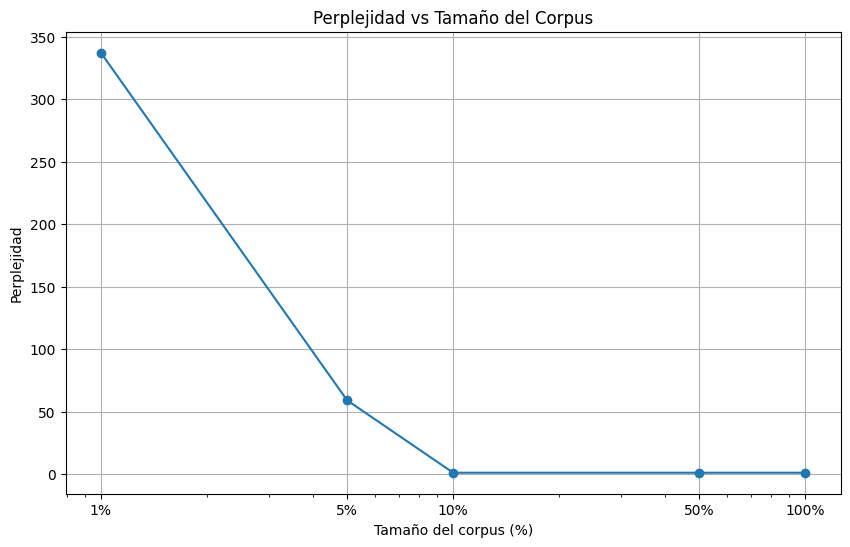

In [254]:
sentence = "el proyecto de la construcción es grande y complejo"
results = evaluatePerplexityOverSizes(comments, sentence)
plotPerplexityResults(results)

Con 1% del corpus, la perplejidad es muy alta sobrepasando 400, lo que indica que el modelo tiene muy poca información para poder predecir correctamente las transiciones entre palabras. Cuando se llega al 5% y 10% se observa una reducción significativa de la perplejidad, lo cual muestra que el modelo ya es capaz de reconocer patrones útiles y a partir del 10% en adelante, la perplejidad se estabiliza cerca de 0, lo cual sugiere que la oración se encuentra cubierta por el modelo y agregar más datos no mejorará significativamente los resultados para esta oración.

## Evaluación con 3-gramas, 4-gramas y 5-gramas

Se busca evaluar cómo cambia el modelo al aumentar el contexto de las palabras, comparar la perplejidad con la del modelo de bigramas y ver si mejora el rendimiento en las oraciones de prueba.

In [255]:
def trainNgramModel(comments, n):
    tokens = []
    for sentence in comments:
        tokens.extend(sentence.strip().split())

    ngram_list = list(ngrams(tokens, n))
    cfd = ConditionalFreqDist()

    for ng in ngram_list:
        context = tuple(ng[:-1])
        word = ng[-1]             
        cfd[context][word] += 1

    model = {}
    for context in cfd:
        total = cfd[context].N()
        model[context] = {}
        for word in cfd[context]:
            model[context][word] = cfd[context][word] / total

    vocab = set(tokens)
    return model, len(vocab)

In [256]:
def calculateNgramPerplexity(sentence, ngramsProbability, vocabSize, n):
    tokens = sentence.split()
    N = len(tokens)
    
    if N < n:
        return float('inf')

    log_prob_sum = 0.0
    for i in range(N - n + 1):
        ngram = tuple(tokens[i:i + n])
        prob = ngramsProbability.get(ngram[:-1], {}).get(ngram[-1], 0)
        if prob == 0:
            prob = 1 / (vocabSize + 1)
        log_prob_sum += math.log(prob)

    perplexity = math.exp(-log_prob_sum / (N - n + 1))
    return perplexity

In [257]:
def plotNgramPerplexity(results):
    n_vals, perplexities = zip(*results)
    plt.figure(figsize=(8, 5))
    plt.plot(n_vals, perplexities, marker='o')
    plt.title("Perplejidad vs Tamaño del N-grama")
    plt.xlabel("Tamaño del N-grama")
    plt.ylabel("Perplejidad")
    plt.grid(True)
    plt.xticks(n_vals)
    plt.show()

In [258]:
def evaluatePerplexityOverNgramSizes(comments, testSentence, n=[2, 3, 4, 5]):
    results = []
    for n_size in n:
        bigramsProbability, vocabSizeC = trainNgramModel(comments, n_size)
        pp = calculateNgramPerplexity(testSentence, bigramsProbability, vocabSizeC, n_size)
        results.append((n_size, pp))
    return results

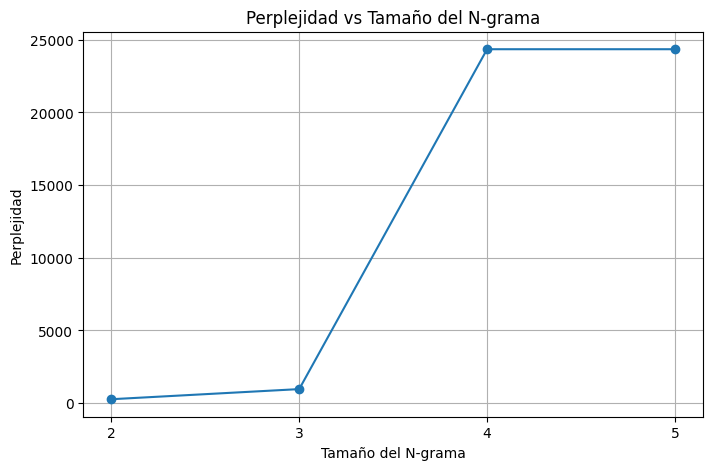

In [259]:
sentence = "el proyecto de la construcción es grande y complejo"
results = evaluatePerplexityOverNgramSizes(comments, sentence)
plotNgramPerplexity(results)

Se observa que medida que el valor de n aumenta, la perplejidad también lo hace significativamente, especialmente entre los 3-gramas y los 4-gramas. Esto se debe a que con valores más altos de n, se vuelve menos probable que el modelo haya detectectado esa secuencia de palabras en el corpus, provocando muchos casos de probabiliid suavizada, lo cual aumenta la respectiva perplejidad. 

Aunque los modelos con n-gramas más largos podrían capturar dependencias más complejas entre palabras, requieren un corpus más grande y diverso para ser efectivos. 

## Efecto del tamaño del corpus y valor de n sombre el desempeño de los modelos

En los modelos evaluados, se observó que el tamaño del corpus tiene una fuerte relación en el tamaño de la perplejidad ya que a medida que se incrementa el porcentaje de corpus, la perplejidad se reduce significativamente. Esto es debido a que corpus más grandes permiten al modelo observar más combinaciones de palabras, lo cual reduce en parte el uso del suavizado y mejora la estimación de probabilidades para ciertos grupos de oraciones.

Por otro lado, el valor de n en los n-gramas también influye en el desempeño de los modelos. A medida que este valor crece, el modelo requiere más contexto para realizar predicciones más precisas. Esto puede provocar un aumento de perplejidad si el corpus no es lo suficientementne grande como para cubrir con todas las posibles combinaciones. En este caso con un corpus que no es muy amplio, es más útil emplear ordenes menores de n para contar un mejor equilibrio entre la precisión y la cobretura.

De esta forma, se determina que para obtener mejores valores de perplejidad sobre distintas oraciones de prueba, se requiere un corpus más grande a medida que aumenta el valor de n y en corpus pequeños, los bigramas y trigramas tienden a ser más eficientes.

## Esparsidad

La esparsidad ocurre cuando muchas combinaciones posibles de palabras no aparecen en el corpus evaluado. Esto es más evidente en modelos con n-gramas de mayor orden (como los que se observan en las gráficas con el 4 o el 5), donde requieren de un contexto más amplio y por lo tanto secuencias más específicas. Resultado de esto es un incremento en la perplejidad porque el modelo no es capaz de asignar buenas probabilidades a secuencias no tan frecuentes. Incluso se puede ver más limitado cuando el corpus es más pequeño.

De esta forma, la esparsidad es un valor clave a considera cuando se trabaja con corpus pequeños o medianos ya que limita el rendimiento con n-gramas de orden alto afectando directamente su capacidad de generalizar.